In [ ]:
#default_exp estimators.tree

Project definitions:

- Set a method called dfit or overwrite fit method in order to have sklearn pipeline support?
- Delegates for an instance of estimator inside class or increment classes through factories (better support in sklearn pipelines)?


- [X] TODO: Solve Tree Predict mistery
- [ ] TODO: make gaussian process interface
- [ ] TODO: make meta bagged randomized prior class


- [X] TODO: make boosting and baging tree estimator classes
- [X] TODO: implement bagging and boosting meta estimator (include sampling from sub models)
- [X] TODO: include target scaling in pipeline
- [ ] TODO: make a "density" method, that returns a RandomVariable class
- [ ] TODO: Create DensityEstimator Base Class containing sample and density methods (density calls sample and returns RV CLASS)
- [ ] TODO: Mean, Variance and Entropy explainer tool (LIME, SHAP, foressts...)
- [ ] TODO: Decide wether to allow multi output (doesnt model well multivariate bimodal joint probabilities, cheeky to sample (two different random samples))

In [2]:
#hide
from nbdev.showdoc import *

# Tree based density estimators -

Density estimators based on DecisionTree algorithms. They're very useful because they handle well heterogeneous data

In [3]:
#export
from warnings import warn

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, normalize, QuantileTransformer, FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor

try:
    from sparse_dot_topn import awesome_cossim_topn
except ImportError as e:
    warn(f"{e}")
    warn("sparse_dot_topn module not installed, will use sklearn NearestNeighbors for vector query")
    

In [4]:
# export
from sklearn.base import BaseEstimator
class BaseDensityEstimator(BaseEstimator):
    @classmethod
    def load(self,path): pass 'load with dill'
    def save(self,): pass 'save with dill'
    def dfit(self,): pass    
    def dpredict(self, samples):     
        return RVArray(samples)
    def sample(self): pass
        

In [441]:
#export
def pad_to_shape(array, shape):
    arr = np.zeros(shape)    
    arr[tuple(slice(0,i) for i in array.shape)] = array
    return arr

def cos_sim_query(query_vector, query_space, n_neighbors=50, lower_bound=0.0):
    
    try:
        sim_matrix = (awesome_cossim_topn(normalize(query_vector), normalize(query_space).T,
                                         ntop=n_neighbors, lower_bound=lower_bound))     
    except NameError:
        sim_matrix = normalize(query_vector.dot(query_space.T))
        
    sim_matrix = sim_matrix.tocoo()
    idx = []
    sim = []
    arr_sizes = []
    for row in range(sim_matrix.shape[0]):
        s = sim_matrix.data[sim_matrix.row == row]
        i = sim_matrix.col[sim_matrix.row == row]
        sim.append(s)
        idx.append(i)
        arr_sizes.append(len(s))
    
    max_size = max(arr_sizes)
    idx = np.array([pad_to_shape(i, max_size) for i in idx]).astype(int)
    sim = np.array([pad_to_shape(s, max_size) for i in sim])
    if idx.shape[1] == 0:
        raise ValueError('No similarity greater than lower_bound found. Choose a lower threshold.')
    return  idx, sim


class CustomMultiOutputRegressor(MultiOutputRegressor):
    '''Custom multioutput for multioutput cases except random forests (which handles multi output directly)'''
    def apply(self,X):
        result = [estim.apply(X) for estim in self.estimators_]
        return np.concatenate(result, axis = -1)
    def sample(self, X, sample_size = None, weights = None):
        result = [estim.sample(X) for estim in self.estimators_]
        return np.concatenate(result, axis = -1)

class EnsembleTreesDensityMixin:    
    '''Base Class containing important methods for building Naive and Similarity Density Tree estimators'''
    def _fit_leaf_sample_graph(self, X):
        nodes_array = self.apply(X)
        encoder = OneHotEncoder()
        self.leaf_node_graph = encoder.fit_transform(nodes_array)
        self.encoder = encoder

    def _make_leaf_node_graph(self, X):
        return self.encoder.transform(self.apply(X))

    def _make_leaf_node_data(self, X, y):
        # create node to data mapper
        y = pd.DataFrame(y)
        node_indexes = self.apply(X)
        tree_node_values_mapper_list = []
        for tree in range(node_indexes.shape[1]):
            tree_node_values_mapper_list.append(dict(
                y.assign(_NODE=node_indexes[:, tree]).groupby('_NODE').apply(
                    lambda x: [x[col].values.tolist() for col in x if not col == '_NODE'])))
        return dict(enumerate(tree_node_values_mapper_list))
    
    def _query_idx_and_sim(self, X, n_neighbors, lower_bound):        
        idx, sim = cos_sim_query(
            self._make_leaf_node_graph(X), self.leaf_node_graph, n_neighbors=n_neighbors, lower_bound=lower_bound)        
        return idx, sim
    
    def _similarity_sample(self, X, sample_size = 100, weights = None, n_neighbors = 10, lower_bound = 0.0, alpha = 1):
        idx, sim = self._query_idx_and_sim(X ,n_neighbors=n_neighbors, lower_bound=lower_bound)                
        idx, sim = np.array(idx), np.array(sim)
        p = self._handle_sample_weights(weights, sim, alpha)        
        samples = []
        for i in range(len(idx)):            
            sampled_idxs = np.random.choice(idx[i], size = sample_size, replace = True, p = p[i])
            samples.append(self.y_[sampled_idxs])
        
        return np.array(samples)
    
    def _similarity_empirical_pdf(self, X, weights = None, n_neighbors = 30, lower_bound = 0, alpha = 1):
        
        idx, sim = cos_sim_query(
            self._make_leaf_node_graph(X),
            self.leaf_node_graph,
            n_neighbors=n_neighbors, lower_bound=lower_bound)
        p = self._handle_sample_weights(weights, sim, alpha)        
        return np.array([self.y_[i] for i in idx]), p
    
    def _sim_predict(self, X, weights, n_neighbors, lower_bound, alpha):                
        '''wieghts must be None or callable that operates on similarity values'''

        values, weights = self._similarity_empirical_pdf(X, weights, n_neighbors, lower_bound, alpha)
        
        y_multioutput = (len(values.shape) - 1) > 1
        if y_multioutput:
            y_dim = values.shape[-1]
            weights = np.repeat(weights, y_dim, axis = -1).reshape(*weights.shape, y_dim)
            return np.average(values, weights = weights, axis = -2)    
        else:
            return np.average(values, weights = weights, axis = -1)

    
    def _handle_sample_weights(self, weights, sim, alpha):
        if weights is None:                        
            return np.array([normalize((i**alpha).reshape(1,-1) + 1e-9, norm = 'l1').flatten() for i in sim])
        else:
            return np.array([normalize((weights(i)).reshape(1,-1) + 1e-9, norm = 'l1').flatten() for i in sim])
    
    def _streaming_fit(self, X):
        '''
        Adds new data to leaf nodes, kind of like a posterior
        '''

## NaiveForestEstimator - 

Estimates the conditional distribution based on leaf samples of all generated trees in the forest

In [222]:

def NaiveTreeEnsemble(estimator):    
    
    class NaiveTreeEnsemble(estimator.__class__, EnsembleTreesDensityMixin):
        
        def __init__(self):            
            super().__init__(**estimator.get_params())            
            
        def __repr__(self):
            return self.__class__.__name__

        def __getitem__(self, idx):
            return self[idx]
            
        def fit(self, X, y = None):
            super().fit(X,y)
            self.tree_node_values_mapper = self._make_leaf_node_data(X, y)
            self.y_dim = y.shape[-1] if len(y.shape) > 1 else 1
            return self
    
        def sample(self, X, sample_size = 100, weights = None):
            node_indexes = self.apply(X)
            drawn_samples = []
            for sample in range(node_indexes.shape[0]):
                row_samples = [[] for _ in range(self.y_dim)]
                for tree in range(node_indexes.shape[1]):
                    node = node_indexes[sample, tree]
                    sampled_values = self.tree_node_values_mapper[tree][node]
                    for dimension in range(len(sampled_values)):
                        row_samples[dimension] += sampled_values[dimension]
                drawn_samples.append(np.array(row_samples).reshape(-1,self.y_dim))
            return np.array(drawn_samples)
       
    return NaiveTreeEnsemble()


# ForestSimilarityEstimator - 

Estimates the conditional distribution based on samples from dataset taking into account the `leaf_sample_graph`

In [307]:
def SimilarityTreeEnsemble(estimator):    
    
    class SimilarityTreeEnsemble(estimator.__class__, EnsembleTreesDensityMixin):
        
        def __init__(self, alpha = 1, n_neighbors = 30, lower_bound = 0.0):            
            super().__init__(**estimator.get_params())     
            self.n_neighbors = n_neighbors
            self.lower_bound = lower_bound
            self.alpha = alpha
            
        def __repr__(self):
            return self.__class__.__name__
            
        def fit(self, X, y = None):        
            super().fit(X,y)        
            self._fit_leaf_sample_graph(X)
            self.y_ = y
            return self
    
        def sample(self, X, sample_size = 10, weights = None, n_neighbors = None, lower_bound = None, alpha = None):
            '''wieghts should be callable (recieves array returns array of same shape) or None'''
            n_neighbors, lower_bound, alpha = self._handle_similarity_sample_parameters(n_neighbors, lower_bound, alpha)
                
            return super()._similarity_sample(
                X = X, sample_size = sample_size, weights = weights, n_neighbors = n_neighbors,
                lower_bound = lower_bound, alpha = alpha
            )
        
        def sim_predict(self, X, weights = None, n_neighbors = None, lower_bound = None, alpha = None):
            n_neighbors, lower_bound, alpha = self._handle_similarity_sample_parameters(n_neighbors, lower_bound, alpha)
            return self._sim_predict(X, weights, n_neighbors, lower_bound, alpha)
        
        def _handle_similarity_sample_parameters(self, n_neighbors, lower_bound, alpha):
            
            if (n_neighbors is None) & (lower_bound is None):
            
            if n_neighbors is None:
                n_neighbors = self.n_neighbors
            if lower_bound is None:
                lower_bound = self.lower_bound
            if alpha is None:
                alpha = self.alpha
            
            return n_neighbors, lower_bound, alpha
       
    return SimilarityTreeEnsemble()

## Tests

In [320]:
#
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor

from sklearn.datasets import make_regression

X,y = make_regression(
    n_samples=10000,
    n_features=30,
    n_informative=15,
    n_targets=3,
    bias=900,
    effective_rank=None,
    tail_strength=2,
    noise=0.2,
    shuffle=True,
    coef=False,
    random_state=None
)

bimodal_msk = np.random.randint(0,2,y.shape[0]).astype(bool)

y[bimodal_msk] = -abs(y[bimodal_msk])


#sns.distplot(y)
sns.jointplot(y[:,0],y[:,1])

X_train, X_test = X[:8000], X[8000:]
y_train, y_test = y[:8000], y[8000:]

We can see that forest estimators are better in dealing with bimodal data

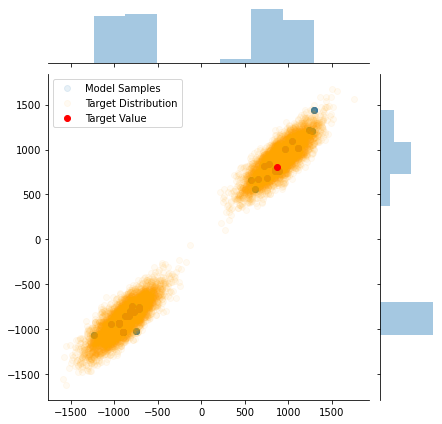

In [543]:
i = 55
estimator = RandomForestRegressor(n_estimators = 10,min_samples_leaf = 2)
density_estimator = SimilarityTreeEnsemble(estimator).fit(X_train,y_train)

samples = density_estimator.sample(X_test[i:i+1], sample_size = 700, alpha = 5)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

We can see that the naive estimator struggles to estimate density of correlated bimodal targets. it estimates well the marginal
distributions bot poorly the joint distributions

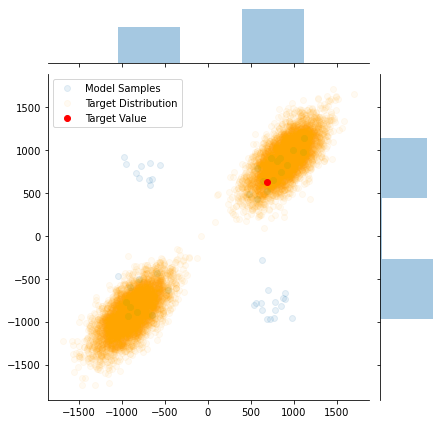

In [196]:
i = 55
estimator = RandomForestRegressor(n_estimators = 10,min_samples_leaf = 2)
density_estimator = NaiveTreeEnsemble(estimator).fit(X_train,y_train)

samples = density_estimator.sample(X_test[i:i+1], sample_size = 700)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()
